In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/LLIE_Project'
    print(path_to_file)

    # change current path to the folder containing "file_name"
    os.chdir(path_to_file)
    !pwd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/LLIE_Project
/content/gdrive/My Drive/LLIE_Project


In [11]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from DatasetAndAugmentation.LowHighDataAugment import PairedTransforms
from DatasetAndAugmentation.LowHightDataset import LOLPairedDataset
import matplotlib.pyplot as plt
from model.model import RELLIE
try:
  from torchmetrics import StructuralSimilarityIndexMeasure
except:
  !pip install torchmetrics
  from torchmetrics import StructuralSimilarityIndexMeasure

import torch
import torch.nn as nn
from torch.optim import AdamW, Adam, SGD

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
     -------------------------------------- 961.5/961.5 kB 8.7 MB/s eta 0:00:00


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Define the dir of the dataset

In [13]:
# direction of the dataset
dataset_dir = "/path/to/dataset"
# directory of low-light images
train_low_dir = "./LOLdataset/train/low"
# directory of high-light images
train_bright_dir = "./LOLdataset/train/high"

# test
test_low_dir = "./LOLdataset/test/low"
test_bright_dir = "./LOLdataset/test/high"

# create the train/test pic transformer, dataset and dataLoader

In [14]:
# create transform class to transform the image into tensor
train_batch_size = 2
train_transform = PairedTransforms(image_size=(400, 600), train=True)
train_dataset = LOLPairedDataset(train_low_dir, train_bright_dir, transform=train_transform, train=True)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)


test_transform = PairedTransforms(image_size=(400, 600), train=False)
test_dataset = LOLPairedDataset(test_low_dir, test_bright_dir, transform=train_transform, train=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Initialize the model

In [15]:
model = RELLIE().to(device)
lr = 0.001
optimizer = SGD(
    model.parameters(), lr=lr
)


class SSIMLoss(nn.Module):
    def __init__(self, window_size=11, reduction='elementwise_mean'):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure(
            data_range=1.0,  # For normalized images [0,1]
            kernel_size=window_size,
            reduction=reduction
        )

    def forward(self, img1, img2):
        """
        Compute SSIM loss between two images.

        Args:
            img1: Output from RetinexNet (range ~[-1,1] after MeanShift)
            img2: Ground truth (range [0,1])

        Returns:
            loss: 1 - SSIM (higher is worse)
        """
        # Normalize Retinex output to [0,1] if needed
        if torch.min(img1) < 0:
            img1 = (img1 + 1) / 2  # Convert [-1,1] to [0,1]

        # Ensure both images are float32 and in [0,1]
        img1 = img1.float().clamp(0, 1)
        img2 = img2.float().clamp(0, 1)

        return 1 - self.ssim(img1, img2)  # Lower is better

mse_loss = nn.MSELoss()
ssim_loss = SSIMLoss(window_size=11).to(device)

c:\Users\xiaoyicong\anaconda3\lib\site-packages\torchmetrics\utilities\prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


In [ ]:

torch.cuda.memory_allocated()

1257147392

In [ ]:
torch.cuda.memory_allocated()

1257147392

# Pipline of training Process

In [ ]:
def train_one_epoch(model, train_loader, optimizer, epoch = 0):
    running_total = 0
    running_ref = 0
    running_dec = 0
    running_ill = 0
    num_batches = 0
    for batch in train_loader:
        input_low_light = batch["low"].to(device)
        target_high_light = batch["bright"].to(device)
        # forward
        reflectance_low_light,\
            reflectance_high_light,\
                illumination_low_light,\
                    illumination_high_light,\
                        enhanced_illumination = model(input_low_light, target_high_light, 'train')

        # calculate loss
        assert reflectance_low_light.shape == reflectance_high_light.shape
        assert illumination_low_light.shape == illumination_high_light.shape
        assert reflectance_high_light.shape == target_high_light.shape
        decomposition_loss = ssim_loss(reflectance_high_light * illumination_high_light, target_high_light) + \
            ssim_loss(reflectance_low_light * illumination_low_light, input_low_light)
        reflectance_loss = mse_loss(reflectance_low_light, reflectance_high_light)
        illumination_enhance_loss = ssim_loss(enhanced_illumination * reflectance_low_light, target_high_light)

        total_loss = 1.5 * decomposition_loss + 0.75 * reflectance_loss + 2.0 * illumination_enhance_loss

        running_dec += decomposition_loss.detach().item()
        running_ref += reflectance_loss.detach().item()
        running_ill += illumination_enhance_loss.detach().item()
        running_total += total_loss.detach().item()

        # backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        num_batches += 1

    print(f'Epoch {epoch + 1}:\t Total Loss = {running_total / num_batches}\t d_loss = {running_dec / num_batches}\t r_loss = {running_ref / num_batches}\t i_loss = {running_ill/num_batches}')


def evaluate(model, test_loader):
    running_total = 0
    num_batches = 0
    with torch.no_grad():
      for batch in test_loader:
          input_low_light = batch["low"].to(device)
          target_high_light = batch["bright"].to(device)

          # forward
          predict_high_light = model(input_low_light, None, 'eval')

          loss = ssim_loss(predict_high_light, target_high_light)
          running_total += loss.item()
          num_batches += 1

    print(f"Evaluation on test set: SSIM Loss = {running_total / num_batches}")


In [ ]:
model_dict_folder = "./model_files_SGD"
if not os.path.exists(model_dict_folder):
    os.makedirs(model_dict_folder)

starting_epoch = 0
load_model = False

if load_model:
  model.load_state_dict(torch.load(f'epoch_{starting_epoch}_state.pt'), weights_only=True)

for epoch in range(starting_epoch, 200):
    if epoch % 20 == 1:
      lr = lr / 2
      optimizer = Adam(model.parameters(), lr=lr)

    train_one_epoch(model, train_loader, optimizer, epoch)
    torch.save(model.state_dict(), os.path.join(model_dict_folder, f'epoch_{epoch}_state.pt'))
    evaluate(model, test_loader)

Epoch 1:	 Total Loss = 2.6098170731783896	 d_loss = 1.1099896266627214	 r_loss = 5.3534300926863244e-09	 i_loss = 0.4724163204554177
Evaluation on test set: SSIM Loss = 0.4693897008895874
Epoch 2:	 Total Loss = 1.716276941966618	 d_loss = 0.7627167350961348	 r_loss = 0.0005443299194413461	 i_loss = 0.2858967987107642
Evaluation on test set: SSIM Loss = 0.26028982003529866
Epoch 3:	 Total Loss = 1.4626640822171184	 d_loss = 0.6848849843068378	 r_loss = 6.674177468923345e-05	 i_loss = 0.21764327322014074
Evaluation on test set: SSIM Loss = 0.21531654596328736
Epoch 4:	 Total Loss = 1.4135102575698508	 d_loss = 0.6696793186811754	 r_loss = 5.151307735370375e-05	 i_loss = 0.20447632118507666
Evaluation on test set: SSIM Loss = 0.22713302373886107
Epoch 5:	 Total Loss = 1.3873619341555936	 d_loss = 0.6600830518169167	 r_loss = 3.6596830356266676e-05	 i_loss = 0.19860495387771984
Evaluation on test set: SSIM Loss = 0.22264604171117147
Epoch 6:	 Total Loss = 1.3702766073584065	 d_loss = 0.653

KeyboardInterrupt: 

# Visualize the output of model

In [ ]:
load_model = False

if load_model:
    model.load_state_dict(torch.load('./model_files/epoch_13_state.pt'), weights_only=True)

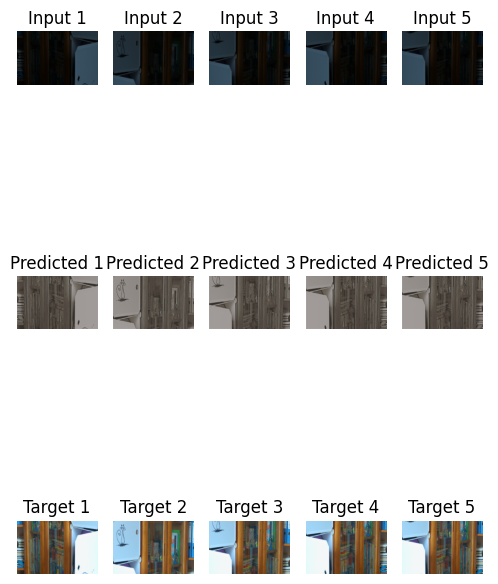

In [ ]:
num_images_show = 5
fig, axes = plt.subplots(3, num_images_show, figsize=(3 * train_batch_size, 9))
for i in range(num_images_show):
    batch = next(iter(test_loader))
    input_low_light = batch["low"].to(device)
    #print(input_low_light)
    target_high_light = batch["bright"].squeeze(0).to(device)

    #print(target_high_light)
    with torch.no_grad():
      predict_high_light = model(input_low_light, None, 'eval').squeeze(0)


    predict_high_light_PIL, target_high_light_PIL = train_transform.tensor2PIL(predict_high_light, target_high_light)
    input_low_light_PIL, _  = train_transform.tensor2PIL(input_low_light.squeeze(0), None)

    # 第1行: Picture input into the model
    axes[0, i].imshow(input_low_light_PIL)
    axes[0, i].set_title(f"Input {i+1}")
    axes[0, i].axis('off')

    # 第2行: Picture output from the model, augmented by the model
    axes[1, i].imshow(predict_high_light_PIL)
    axes[1, i].set_title(f"Predicted {i+1}")
    axes[1, i].axis('off')

    # 第3行：The target picture
    axes[2, i].imshow(target_high_light_PIL)
    axes[2, i].set_title(f"Target {i+1}")
    axes[2, i].axis('off')
plt.show()